### Portfolio VaR

The Value at Risk (VaR) of a portfolio is a measure of the potential loss a portfolio is at risk of. The risk is given as the most that will be lost (so is at risk) over a certain time horizon, within a given confidence level; for example, a 1 day 95 VaR of \\$50,000 states that 95% of the time we will loose at most \$50,000 over the next day". 

There are three standard methods of calculating Value at Risk: Monte Carlo, Parametric, and Historic. I will first calculate VaR at 95\% using the Monte Carlo method for a 10 day horizon. To keep things simple, for the Monte Carlo demonstration, I will limit the portfolio to one stock, so the portfolio return and volitility is the stock return and volitility.

I also provide an example of a Parametric and Historic calculation. It is important to note that VaR only gives the possible loss within at a certain confidence level, it does not give any indication of potential loss beyond the confidence level. Expected Shortfall (ES) provides a estimate of potential loss beyond the confidence level and I provide a brief ES example.  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
import scipy.stats as stats
import statsmodels.api as sm

Read the adjusted close price of the stock, for demonstation purposes I will limit the dataset to about 10 years. 

In [2]:
start_date = '2010-01-01'
end_date = dt.date.today()

df_port1 = web.DataReader('GOOG','yahoo',start=start_date,end=end_date)['Adj Close']
df_port1.tail()

Date
2020-11-19    1763.920044
2020-11-20    1742.189941
2020-11-23    1734.859985
2020-11-24    1768.880005
2020-11-25    1771.430054
Name: Adj Close, dtype: float64

To calculate VaR, I will run a Monte Carlo simulation of future prices. An Ito process will be used to model the future price paths.

In [3]:
# calc the daily return and std dev for use in the Ito process
discrete_returns = df_port1.pct_change()[1:].values
port_returns = np.log(1 + discrete_returns)

mu = port_returns.mean()
S = port_returns.std()
variance = port_returns.var()

n_iterations = 200

# number of periods into the future to simulate prices
# we will use a time horizon of 10 days
horizon = 10 

# build a matrix of random normal diviates, to be used as the diviates in the Ito process
rand_deviates = np.random.randn(horizon,n_iterations)

# matrix of simulated stock returns
rand_returns = np.exp((mu - .5 * variance) + (S * rand_deviates))

Build a matrix of prices and display the simulated price paths

In [4]:
# matrix to hold simulated prices
prices = np.zeros_like(rand_returns)

# the first entry for each simulation path is initilsed with the current closing price
day0_prices = np.zeros((1,n_iterations))
last_closing_price = df_port1[-1]
day0_prices[:] = last_closing_price
prices = np.vstack((day0_prices, prices)) 

# the rest of the entries are populated with the previous days price multiplied by a random simulated stock return
for t in range(1,np.shape(prices)[0]):
    prices[t] = prices[t-1] * rand_returns[t-1]


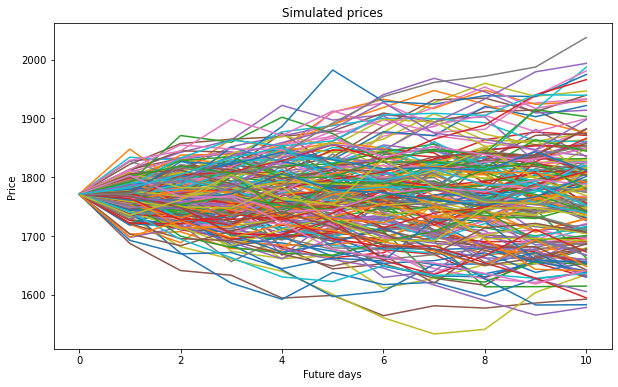

In [5]:
fig = plt.figure(figsize=(10,6))
plt.plot(prices)
plt.title("Simulated prices")
plt.xlabel("Future days")
plt.ylabel("Price")
plt.show()

Now that we have a possible future distribution of stock prices we can get the price at the required percentile for the day in queston.

In [6]:
# assign the portfolio value so that we can give dollar VaR
port_value = 1e6

# alpha of 5 to give a 95 confidence level
alpha = 5.0
var95_price = np.percentile( prices[len(prices) -1 , :], alpha , interpolation='higher')
var95_return = var95_price / last_closing_price
var95_dollar_loss = port_value  - (port_value * var95_return)

print('The {} day VaR at 95% C.I.for a portfolio valued at ${:,.2f} is ${:,.2f}' 
      .format(horizon,port_value,var95_dollar_loss))
print('This can be interpreted as 95% of the time our {} day loss will not exceed ${:,.2f}' 
      .format(horizon,var95_dollar_loss))

The 10 day VaR at 95% C.I.for a portfolio valued at $1,000,000.00 is $77,228.97
This can be interpreted as 95% of the time our 10 day loss will not exceed $77,228.97


### Parametric VaR
I will now calculate the 1 day VaR for a portfolio of stocks using the Parametric method. I first read in the stock data and then calculate the portfolio expected return and standard deviation. The Parametric method for calculating VaR has the advantage of simplicity, and requires only the portfolio expected return and standard deviation.

In [7]:
assets = ['GOOG','MSFT','CSCO','AMZN']

df = pd.DataFrame(columns=assets)
for asset in assets:
    df[asset] = web.DataReader(asset,'yahoo',start=start_date,end=end_date)['Adj Close']
    
df.tail()

,GOOG,MSFT,CSCO,AMZN
Date,,,,
2020-11-19,1763.920044,212.419998,41.169998,3117.020020
2020-11-20,1742.189941,210.389999,40.970001,3099.399902
2020-11-23,1734.859985,210.110001,41.639999,3098.389893
2020-11-24,1768.880005,213.860001,42.610001,3118.060059
2020-11-25,1771.430054,213.869995,42.500000,3185.070068


In [8]:
# calculate the means of the returns for each asset
discrete_returns = np.array(df[assets].pct_change()[1:])
log_returns = np.log(1 + discrete_returns)
log_returns_means = log_returns.mean(axis=0)

# get the covariance matrix of the returns
cov_matrix = np.cov(log_returns,bias=True,rowvar=0)

In [9]:
# assign arbitary weights to each holding
weights = [.25,.25,.10,.40]

# mean daily portfolio return
mu = np.dot( log_returns_means ,weights)

# portfolio standard deviation
S = np.sqrt(np.dot(np.transpose(weights),np.dot(cov_matrix,weights)))

In [10]:
#expected mean dollar value
port_expected_value = port_value * (1 + mu)

# dollar standard deviation
port_dollar_std = port_value * S

# confidence level of 95
alpha = .05

var_port_value = stats.norm.ppf(alpha, port_expected_value,port_dollar_std)
VaR = port_value - var_port_value

print('At a {:.0f}% confidence level, we expect the loss to be no more than ${:,.2f}'
      .format((1-alpha) * 100, VaR))
print('and the value of the portfolio to be no less than ${:,.2f}'
      .format(var_port_value))


At a 95% confidence level, we expect the loss to be no more than $23,365.34
and the value of the portfolio to be no less than $976,634.66


### Requirement of Normal Distribution
Parametric calculations of VaR assume a normal distribution of the returns

Check that the returns are normally distributed, if they are not then VaR can be calculated using the historical method; however, the disadvantage of the historical method is that it is not forward looking.

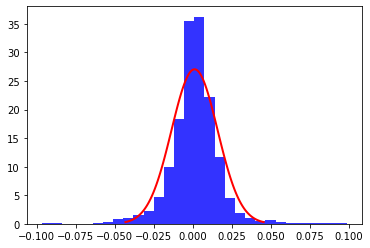

In [11]:
# get the portfolios historical daily returns
returns = np.matrix(df.pct_change()[1:])
port_hist_returns = np.ravel(np.dot(weights,returns.T))

# plot histogram
plt.hist(port_hist_returns,color='blue',bins=30,density=True,alpha = .8)

# plot a normal distribution curve
port_rets_mean = port_hist_returns.mean()
port_rets_std = port_hist_returns.std()
x = np.linspace(port_rets_mean - 3 * port_rets_std, port_rets_mean + 3 * port_rets_std,100)
plt.plot(x, stats.norm.pdf(x,port_rets_mean,port_rets_std),'r', lw=2)

plt.show()

Visual inspection of the histogram indicates that the portfolio returns follow a normal distribution. We can futher check this assumption using a QQ plot

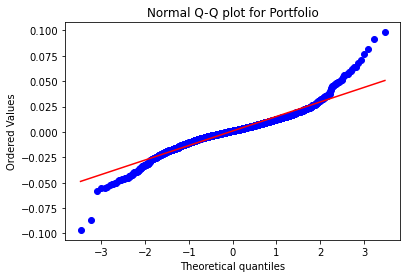

In [12]:
# display Q-Q plot
stats.probplot(port_hist_returns,dist='norm',plot=plt)

plt.title("Normal Q-Q plot for Portfolio")
plt.show()

The QQ-plot for the portfolio indicates that the returns distribution is fat tailed, which was also apparent in the histogram of the portfolio's return distribution. 
It is well known that stock returns are more likely to have a Student T distribution.

### Historical VaR
Historical VaR is the simplest VaR to calculate, involving just getting the required percentile of the historic returns. I calculate the historical returns out to a time horizon, using the square root of time rule.

In [13]:
alpha = 0.05
hist_var = np.quantile(port_hist_returns,alpha,interpolation='higher') 

# use square root rule to calculate out to a horizon
horizon = 10
var_horizon =  port_value * hist_var * np.sqrt(horizon)

print('Historical VaR at {:.0f}% confidence level is ${:,.2f}' .format((1-alpha) * 100, var_horizon * -1))

Historical VaR at 95% confidence level is $70,166.79


### Expected Shortfall

There are a number of drawbacks to using Value at Risk as a loss metric.
* VaR is not additive. The VaR of a portfolio does not equal the sum of the individual VaRs of the assets in the portfolio
* VaR does not give any indication of what the expected loss beyond the confidence level would be 

Expected Shortfall (ES) overcomes these drawbacks. ES, also know as conditional VaR, is the mean of the returns beyond the confidence level threshold.

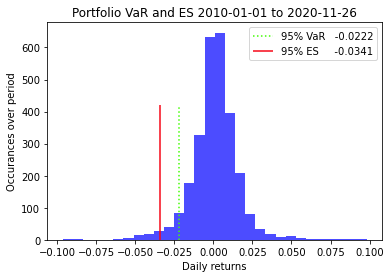

In [14]:
# calculate expected shortfall, and plot the results
hist_es = port_hist_returns[port_hist_returns < hist_var ].mean()

lbl_var = "{:.4f}".format(hist_var)
lbl_es = "{:.4f}".format(hist_es)
freq = plt.hist(port_hist_returns,color='blue',bins=30,alpha=.7)
vline_height = int(freq[0].max() * .65)
plt.vlines(hist_var,0,vline_height,colors='#43fc05',linestyles='dotted',label=f'95% VaR   {lbl_var}')
plt.vlines(hist_es,0,vline_height,colors='#f70515',linestyles='solid',label=f'95% ES     {lbl_es}')
plt.legend()
plt.title("Portfolio VaR and ES {} to {}" .format(start_date,end_date))
plt.ylabel("Occurances over period")
plt.xlabel("Daily returns")
plt.show()
